In [22]:
# https://www.openml.org/d/1508 - dataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import processer

In [23]:
data = pd.read_csv('dataset.csv')
data.head()

,V1,V2,V3,V4,V5,Class
0,0.00,0.00,0.00,0.00,0.00,4
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,2
3,0.10,0.10,0.15,0.65,0.30,3
4,0.08,0.08,0.08,0.98,0.24,2


In [24]:
X = data[data.columns[:-1]]
X.head()

,V1,V2,V3,V4,V5
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


In [25]:
cls, cnt = np.unique(data.Class, return_counts=True)
dict(zip(cls, cnt))

{1: 102, 2: 129, 3: 122, 4: 24, 5: 26}

In [26]:
y = data.Class.apply(lambda status: np.where(cls == status)[0][0])
y.head()

0    3
1    0
2    1
3    2
4    1
Name: Class, dtype: int64

In [27]:
means = X.mean()
means

V1    0.353141
V2    0.355940
V3    0.457655
V4    0.431342
V5    0.456360
dtype: float64

In [28]:
stds = X.std()
stds

V1    0.212018
V2    0.215531
V3    0.246684
V4    0.257545
V5    0.266775
dtype: float64

In [29]:
normX = pd.DataFrame(dict([(column, (X.loc[:, column] - means[column]) / stds[column])
                            for column in X.columns]))
X = normX
X.head()

,V1,V2,V3,V4,V5
0,-1.665623,-1.651461,-1.855232,-1.674824,-1.710652
1,-1.288296,-1.280284,-1.449854,-0.742948,1.662973
2,-1.382628,-1.373078,-1.652543,-0.704120,-0.473656
3,-1.193964,-1.187490,-1.247165,0.849007,-0.586110
4,-1.288296,-1.280284,-1.530930,2.130337,-0.811018


In [30]:
X.mean()

V1   -2.936719e-16
V2   -1.645775e-15
V3    7.834924e-16
V4   -6.545633e-16
V5   -4.049697e-17
dtype: float64

In [31]:
X.std()

V1    1.0
V2    1.0
V3    1.0
V4    1.0
V5    1.0
dtype: float64

In [32]:
def getClass(kt, dt, wt, wp, X, y, argument):
    weights = processer.getClassW(kt, dt, wt, wp, X, y, argument)
    return weights.index(max(weights))

In [33]:
def getConfusionMatrix(kt, dt, wt, wp):
    classesCnt = len(y.unique())
    res = [[0 for _ in range(classesCnt)] for _ in range(classesCnt)]
    for i in range(data.shape[0]):
        expClass = y[i]
        argument = X.loc[i]
        trainX = X.drop([i])
        trainy = y.drop([i])
        predictedClass = getClass(kt, dt, wt, wp, trainX.values, trainy, argument)
        res[expClass][predictedClass] += 1
    return res

In [34]:
def getFscore(cm):
    def getPrecisionRecall(idx):
        tp = cm[idx][idx]
        tp_fp = sum([cm[j][idx] for j in range(len(cm))])
        tp_fn = sum(cm[idx])
        precision = 0 if tp_fp == 0 else tp / tp_fp
        recall = 0 if tp_fn == 0 else tp / tp_fn
        return precision, recall


    def calcFscore(precision, recall):
        if precision + recall == 0:
            return 0
        else:
            return 2 * precision * recall / (precision + recall)


    totalCnt = sum([sum(cm[i]) for i in range(len(cm))])
    microPrecision = sum([getPrecisionRecall(i)[0] * sum(cm[i]) for i in range(len(cm))]) / totalCnt
    microRecall = sum([getPrecisionRecall(i)[1] * sum(cm[i]) for i in range(len(cm))]) / totalCnt
    return calcFscore(microPrecision, microRecall)

In [35]:
distances = []
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        first = X.loc[i].values
        second = X.loc[j].values
        distances.append(processer.getDist("euclidean", first, second))
distances.sort()
total_dists = len(distances)
distances[int(0.90 * total_dists)]

4.232354557741518

In [36]:
def genParams():
    for kt in processer.kernel:
        for dt in processer.distances:
            for wt in ["fixed", "variable"]:
                if wt == "fixed":
                    wps = np.linspace(0.1, 4, 10)
                else:
                    wps = range(1, 101, 10)
                for wp in wps:
                    yield (kt, dt, wt, wp)

In [37]:
maxFscore = -1
bkt = None
bdt = None
bwt = None
bwp = None
for kt, dt, wt, wp in tqdm(list(genParams())):
    ConfusionMatrix = getConfusionMatrix(kt, dt, wt, wp)
    curFscore = getFscore(ConfusionMatrix)
    if curFscore > maxFscore:
        maxFscore = curFscore
        bkt = kt
        bdt = dt
        bwt = wt
        bwp = wp

100%|██████████| 600/600 [18:06<00:00,  1.81s/it]


In [38]:
maxFscore, bkt, bdt, bwt, bwp

(0.8557146559202522, 'triweight', 'manhattan', 'variable', 41)

In [39]:
fScoresFixed = []
hFixed = np.linspace(0.1, 5, 80)
for h in tqdm(hFixed):
    ConfusionMatrix = getConfusionMatrix(bkt, bdt, "fixed", h)
    curFscore = getFscore(ConfusionMatrix)
    fScoresFixed.append(curFscore)

100%|██████████| 80/80 [02:16<00:00,  1.70s/it]


In [40]:
fScoresVariable = []
kVariable = range(1, 201, 2)
for k in tqdm(kVariable):
    ConfusionMatrix = getConfusionMatrix(bkt, bdt, "variable", k)
    cur_f_score = getFscore(ConfusionMatrix)
    fScoresVariable.append(cur_f_score)

100%|██████████| 100/100 [02:55<00:00,  1.76s/it]


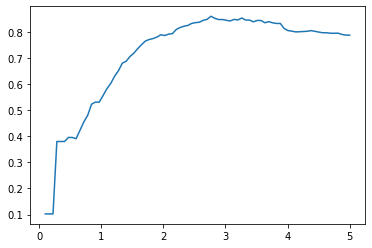

In [41]:
plt.plot(hFixed, fScoresFixed)

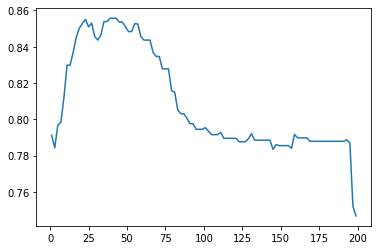

In [42]:
plt.plot(kVariable, fScoresVariable)